In [1]:
# Python : 3.6.13
# Numpy: 1.17.0
# pandas: 0.25.0
# matplotlib: 3.1.1
# scipy: 1.3.1
# scikit-learn: 0.20.0

import os, sys, glob
import pandas as pd
import numpy as np
import matplotlib as mpl
#mpl.use('TKAgg',warn=False, force=True) #set MPL backend.
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.transforms as transforms
import pickle #save/load python data objects (dictionaries/arrays)
import multiprocessing
import itertools
from sklearn import preprocessing
from sklearn.neighbors import NearestNeighbors
import datetime
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

## 使用する関数

In [14]:
# ファイルのLoading/saving
def save_obj(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name ):
# デバック用
    with open(name + '.pkl', 'rb') as f:
# ファイル実行用
    # with open(name + '.pkl', 'rb') as f:
        return pickle.load(f)
#------------------------------------------------------------------------------------------------------------ 
    
    

    
    
#------------------------------------------------------------------------------------------------------------ 

# プロットするための関数

#------------------------------------------------------------------------------------------------------------ 


def make_cmap(colors, position=None, bit =False): 
    #bit=Flaseはcolors = [(1,1,1), (101/255,236/255,101/255)] 
    #bit=Trueはcolors = [(255,255,255), (101,236,101)] →if bit: で形を変形
    bit_rgb = np.linspace(0,1,256) #0~1を256分割
    if position == None:
        position =np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
            
    if bit: #ここでcolorsをbit=Trueの場合と同じ形にする
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
            
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))
    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap
#------------------------------------------------------------------------------------------------------------


# Customised histogram function to help plotting on log scale and other aspects (courtesy of Justin Bray)
def histvals(a, logmin=0.0, cumulative=False, **kwargs):  # **kwargsは辞書型で変数を入れることができる
  """Return x/y values for plotting a histogram."""

  if cumulative: # 累積に関して使うときにもう一度詳しくみた方がいい
    lims = kwargs.pop('bins', [a.min(), a.max()]) # ビンのサイズの最大値と最小値
    density = kwargs.pop('density', False) 
    assert not kwargs, 'Unprocessed kwargs in histvals.' # kwargsに使用されてない引数がある場合アラートする

    # Reduce length of array, if possible, by combining duplicate values.
    bins,counts = np.unique(a, return_counts=True)
    #counts, bins = np.histogram(a, **kwargs)

    bins = np.concatenate(( [lims[0]], bins, [lims[-1]] ))
    counts = np.concatenate(( [0], np.cumsum(counts) )) # np.cumsum(counts)で累積している

    if density:
      counts = counts*1./counts.max()
  else:
    counts, bins = np.histogram(a, **kwargs) #countには各ビンの度数 binsにはビンの境界値が入る

  x = np.concatenate( list(zip( bins[:-1], bins[1:] )) ) #軸が対数であるため、わかりやすく表示するため、x,yはどちらも値を2つずつ持ってる
  y = np.concatenate( list(zip( counts,    counts   )) )

  if not cumulative:
    x = np.concatenate(( [x[0]], x, [x[-1]] ))
    y = np.concatenate(( [0],    y,  [0]    ))

  # 負のあたいがあったとしてもうまくプロットされるようにloglim(非常に小さい正の値)にしてる
  if logmin:
    y = (y > 0)*y + (y <= 0)*logmin
  return x,y
#------------------------------------------------------------------------------------------------------------



#------------------------------------------------------------------------------------------------------------ 

# 解析するための関数

#------------------------------------------------------------------------------------------------------------ 




def plot_basic_hists(df, df_spec, place):
    bins = np.linspace(14, 26,150) #10~26の範囲を100分割し、それをビンのサイズとする
    linewidth = 1 #線の太さ
    plt.subplots(1, 1, figsize=(6,3.5)) #図の個数指定&サイズ指定

    xvar='i_psfflux_mag' # 指定するカラム
    
    x, s = histvals(df[df['class_pred']=='STAR'][xvar].values, bins=bins) #xにはビンのの値が２つずつ入ってる sにはヒストグラムの値が格納
    x, g = histvals(df[df['class_pred']=='GALAXY'][xvar].values, bins=bins)
    x, q = histvals(df[df['class_pred']=='QSO'][xvar].values, bins=bins)

    plt.plot(x, s, label='Stars: {0:.0f}'.format(np.sum(s)/2), color=star_c, linewidth=linewidth)
    plt.plot(x, g, label='Galaxies: {0:.0f}'.format(np.sum(g)/2), color=galaxy_c, linewidth=linewidth)
    plt.plot(x, q, label='Quasars: {0:.0f}'.format(np.sum(q)/2), color=quasar_c, linewidth=linewidth)
    plt.plot(x, g+q+s, label='All sources', color='black', linewidth=0.2, ls='--')

    x, s = histvals(df_spec[df_spec['class']=='STAR'][xvar].values, bins=bins) #xにはビンのの値が２つずつ入ってる sにはヒストグラムの値が格納
    x, g = histvals(df_spec[df_spec['class']=='GALAXY'][xvar].values, bins=bins)
    x, q = histvals(df_spec[df_spec['class']=='QSO'][xvar].values, bins=bins)

    plt.plot(x, s, label='Spec stars: {0:.0f}'.format(np.sum(s)/2), color=star_c, ls='--',linewidth=linewidth)
    plt.plot(x, g, label='Spec galaxies: {0:.0f}'.format(np.sum(g)/2), color=galaxy_c, ls='--',linewidth=linewidth)
    plt.plot(x, q, label='Spec quasars: {0:.0f}'.format(np.sum(q)/2), color=quasar_c, ls='--',linewidth=linewidth)

    plt.yscale('log')
    plt.xlabel('psf i magnitude', fontsize = 13)
    plt.ylabel('Number of sources', fontsize = 13)
    plt.minorticks_on()
    plt.legend(frameon=False)
    plt.tight_layout()
    if mag_lim:
        plt.savefig('HSC_classifynew/' + place + '/mag_lim/New-sources-spec-hist-imag.pdf')
    else:
        plt.savefig('HSC_classifynew/' + place + '/no_mag_lim/New-sources-spec-hist-imag.pdf')
#------------------------------------------------------------------------------------------------------------



def plot_new_feature_hist(df_spec, df_g, df_q, df_s, place):
    print('Making feature histogram plot... features-.pdf')
    
    figsize = (10,3.5)
    linewidth = 1.2
    linewidth_s = 0.8
    elinewidth = 0.5
    capthick = 0.5
    spec_capsize = 1
    photo_capsize = 4
    
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, gridspec_kw=dict(width_ratios=[1,1.3,1]), figsize=figsize)

    plt.sca(ax1) 
    # 特徴
    xlabels = ['g','r','i','z','y']
    plot_columns = ['g_psfflux_mag','r_psfflux_mag', 'i_psfflux_mag', 'z_psfflux_mag', 'y_psfflux_mag']

    # offsetを使うことでプロット同士が被らないようにしている。transでは軸をデータと同じ形式にしている
    offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
    trans = plt.gca().transData

    
    # Photometric sources
    plt.errorbar(plot_columns, df_g[plot_columns].mean(), yerr=df_g[plot_columns].std(), color=galaxy_c, ls=ls, capsize=photo_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='Galaxies: {0}'.format(len(df_g)), transform=trans+offset(-5))
    plt.errorbar(plot_columns, df_q[plot_columns].mean(), yerr=df_q[plot_columns].std(), color=quasar_c, ls=ls, capsize=photo_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='Quasars: {0}'.format(len(df_q)), transform=trans+offset(-1))
    plt.errorbar(plot_columns, df_s[plot_columns].mean(), yerr=df_s[plot_columns].std(), color=star_c, ls=ls, capsize=photo_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='Stars: {0}'.format(len(df_s)), transform=trans+offset(+3))

    # Spectroscopic sources
    a = plt.errorbar(plot_columns, df_spec[df_spec['class']=='GALAXY'][plot_columns].mean(), yerr=df_spec[df_spec['class']=='GALAXY'][plot_columns].std(), color=galaxy_c, ls='--', capsize=spec_capsize, capthick=capthick, linewidth=linewidth_s, elinewidth=elinewidth, label='Spec galaxies: {0}'.format(len(df_spec[df_spec['class']=='GALAXY'])), transform=trans+offset(-3))
    a[-1][0].set_linestyle('--')
    b = plt.errorbar(plot_columns, df_spec[df_spec['class']=='QSO'][plot_columns].mean(), yerr=df_spec[df_spec['class']=='QSO'][plot_columns].std(), color=quasar_c, ls='--', capsize=spec_capsize, capthick=capthick, linewidth=linewidth_s, elinewidth=elinewidth, label='Spec quasars: {0}'.format(len(df_spec[df_spec['class']=='QSO'])), transform=trans+offset(+1))
    b[-1][0].set_linestyle('--')
    c = plt.errorbar(plot_columns, df_spec[df_spec['class']=='STAR'][plot_columns].mean(), yerr=df_spec[df_spec['class']=='STAR'][plot_columns].std(), color=star_c, ls='--', capsize=spec_capsize, capthick=capthick, linewidth=linewidth_s, elinewidth=elinewidth, label='Spec stars: {0}'.format(len(df_spec[df_spec['class']=='STAR'])), transform=trans+offset(+5))
    c[-1][0].set_linestyle('--')

#     plt.legend(frameon=False)
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())
    plt.xticks(np.arange(len(xlabels)), xlabels, rotation=rotation, fontsize=11) # 補助メモリのカスタマイズ
    plt.xlim(-0.4, len(xlabels)-0.6) # auto scale with sticky_edges=False doesn't seem to work, so do manually:
#     plt.xlabel('Feature name', fontsize=13)
    plt.ylabel('Magnitude', fontsize=13)
    plt.yticks(np.arange(16, 25, step=2), fontsize = 10)
    plt.ylim(25,16)
    #ax1.margins(x=0.4)
    #ax1.use_sticky_edges = False
    #ax1.autoscale_view(scalex=True)
    plt.tight_layout()

    # ishape
    plt.sca(ax2)
    x, y = histvals(df_g.ishape.values, bins=bins_i)
    plt.plot(x, y, ls=ls, color=galaxy_c)
    x, y = histvals(df_q.ishape.values, bins=bins_i)
    plt.plot(x, y, ls=ls, color=quasar_c)
    x, y = histvals(df_s.ishape.values, bins=bins_i)
    plt.plot(x, y, ls=ls, color=star_c)
    
    x, y = histvals(df_spec[df_spec['class']=='GALAXY'].ishape.values, bins=bins_i)
    plt.plot(x, y, ls='--', color=galaxy_c, linewidth=0.5)
    x, y = histvals(df_spec[df_spec['class']=='QSO'].ishape.values, bins=bins_i)
    plt.plot(x, y, ls='--', color=quasar_c, linewidth=0.5)
    x, y = histvals(df_spec[df_spec['class']=='STAR'].ishape.values, bins=bins_i)
    plt.plot(x, y, ls='--', color=star_c, linewidth=0.5)
    
    #plt.legend(frameon=False)
    plt.yscale('log')
    plt.xscale('log')
#     plt.xlabel('ishape' , fontsize=13)
    plt.ylabel('Number' , fontsize=13)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    
    
    plt.sca(ax3) 

    xlabels = ['g-r','r-i','i-z','z-y']
    plot_columns = ['g-r','r-i','i-z','z-y']

    # offsetを使うことでプロット同士が被らないようにしている。transでは軸をデータと同じ形式にしている
    offset = lambda p: transforms.ScaledTranslation(p/72.,0, plt.gcf().dpi_scale_trans)
    trans = plt.gca().transData

    # Photometric sources
    plt.errorbar(plot_columns, df_g[plot_columns].mean(), yerr=df_g[plot_columns].std(), color=galaxy_c, ls=ls, capsize=photo_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='Predicted galaxies: {0}'.format(len(df_g)), transform=trans+offset(-5))
    plt.errorbar(plot_columns, df_q[plot_columns].mean(), yerr=df_q[plot_columns].std(), color=quasar_c, ls=ls, capsize=photo_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='Predicted quasars: {0}'.format(len(df_q)), transform=trans+offset(-1))
    plt.errorbar(plot_columns, df_s[plot_columns].mean(), yerr=df_s[plot_columns].std(), color=star_c, ls=ls, capsize=photo_capsize, capthick=capthick, linewidth=linewidth, elinewidth=elinewidth, label='Predicted stars: {0}'.format(len(df_s)), transform=trans+offset(+3))

    # Spectroscopic sources
    a = plt.errorbar(plot_columns, df_spec[df_spec['class']=='GALAXY'][plot_columns].mean(), yerr=df_spec[df_spec['class']=='GALAXY'][plot_columns].std(), color=galaxy_c, ls='--', capsize=spec_capsize, capthick=capthick, linewidth=linewidth_s, elinewidth=elinewidth, label='Galaxies with spectra: {0}'.format(len(df_spec[df_spec['class']=='GALAXY'])), transform=trans+offset(-3))
    a[-1][0].set_linestyle('--')
    b = plt.errorbar(plot_columns, df_spec[df_spec['class']=='QSO'][plot_columns].mean(), yerr=df_spec[df_spec['class']=='QSO'][plot_columns].std(), color=quasar_c, ls='--', capsize=spec_capsize, capthick=capthick, linewidth=linewidth_s, elinewidth=elinewidth, label='Quasars with spectra: {0}'.format(len(df_spec[df_spec['class']=='QSO'])), transform=trans+offset(+1))
    b[-1][0].set_linestyle('--')
    c = plt.errorbar(plot_columns, df_spec[df_spec['class']=='STAR'][plot_columns].mean(), yerr=df_spec[df_spec['class']=='STAR'][plot_columns].std(), color=star_c, ls='--', capsize=spec_capsize, capthick=capthick, linewidth=linewidth_s, elinewidth=elinewidth, label='Stars with spectra: {0}'.format(len(df_spec[df_spec['class']=='STAR'])), transform=trans+offset(+5))
    c[-1][0].set_linestyle('--')
    
    
    plt.gca().yaxis.set_minor_locator(ticker.AutoMinorLocator())
    plt.xticks(np.arange(len(xlabels)), xlabels, rotation=rotation, fontsize=11) # 補助メモリのカスタマイズ
    plt.xlim(-0.4, len(xlabels)-0.6) # auto scale with sticky_edges=False doesn't seem to work, so do manually:
#     plt.xlabel('Feature name' , fontsize=13)
    plt.ylabel('Magnitude Diﬀerence' , fontsize=13)
    plt.yticks(fontsize=10)
    #ax1.margins(x=0.4)
    #ax1.use_sticky_edges = False
    #ax1.autoscale_view(scalex=True)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.tight_layout()

    ax1.tick_params(which='both', right=True)
    ax2.tick_params(which='both', right=True)
    ax3.tick_params(which='both', right=True)

    if mag_lim:
        f.savefig('HSC_classifynew/' + place + '/mag_lim/New-sources-features-perclass.pdf')
    else:
        f.savefig('HSC_classifynew/' + place + '/no_mag_lim/New-sources-features-perclass.pdf')

    '''
    # psf_i - cmod_i　のヒストグラム. Resolved sourceかどうか?
    # dfから探す。これはresolvedを特徴量にしないときのことを考えて.
    plt.sca(ax2)
    x1, y1 = histvals(df.loc[missed_star_as_quasar.index.values].resolved_i.values, bins=bins_res, density=density)
    plt.plot(x1, y1, label='missed stars as quasars', ls=missed_ls, color=star_c)
    x2, y2 = histvals(df.loc[missed_quasar_as_star.index.values].resolved_i.values, bins=bins_res, density=density)
    plt.plot(x2, y2, label='missed quasars as stars', ls=missed_ls, color=quasar_c)
    x3, y3 = histvals(df.loc[correct_star.index.values].resolved_i.values, bins=bins_res, density=density)
    plt.plot(x3, y3, label='correct stars', ls=correct_ls, color=star_c)
    x4, y4 = histvals(df.loc[correct_quasar.index.values].resolved_i.values, bins=bins_res, density=density)
    plt.plot(x4, y4, label='correct quasars', ls=correct_ls, color=quasar_c)
    #plt.legend(frameon=False)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('| PSF i - cmodel i | [magnitude]')
    plt.ylabel('Number')
    plt.tight_layout()
    f.savefig('HSC_analysis_save/psf/features-star-quasar'+plot_data_label+'.pdf')
    '''
    '''
    # Histogram of errors, high error sources classified worse?
    # Searching the original df because we don't use errors as a feature (they don't improve classification results)
    plt.sca(ax2)
    x1, y1 = histvals(df.loc[missed_star_as_quasar.index.values].psferr_r.values, bins=bins_err, density=density)
    plt.plot(x1, y1, label='missed stars as quasars', ls=missed_ls, color=star_c)
    x2, y2 = histvals(df.loc[missed_quasar_as_star.index.values].psferr_r.values, bins=bins_err, density=density)
    plt.plot(x2, y2, label='missed quasars as stars', ls=missed_ls, color=quasar_c)
    x3, y3 = histvals(df.loc[correct_star.index.values].psferr_r.values, bins=bins_err, density=density)
    plt.plot(x3, y3, label='correct stars', ls=correct_ls, color=star_c)
    x4, y4 = histvals(df.loc[correct_quasar.index.values].psferr_r.values, bins=bins_err, density=density)
    plt.plot(x4, y4, label='correct quasars', ls=correct_ls, color=quasar_c)
    #plt.legend(frameon=False)
    plt.yscale('log')
    plt.xscale('log')
    plt.ylim(top=2*10**5)
    plt.xlabel('PSF r error [magnitude]')
    plt.ylabel('Number')
    plt.tight_layout()
    f.savefig('star-quasar-'+plot_data_label+'.pdf')
    '''
#------------------------------------------------------------------------------------------------------------




def plot_new_prob_hist(df, df_g, df_q, df_s,  place):
    print('Plotting probability histograms...')
    bins_p = np.linspace(0,1,200)

    # ------ new plot ------

    # Plot histogram over probabilities
    f, axs = plt.subplots(1, 2, figsize=(10,3.5), sharey=False, sharex=False) # two plots side by side
    plt.sca(axs[0])
    xpg, yg_prob = histvals(df_g.prob_g, bins=bins_p, cumulative=False, density=False)
    xpq, yq_prob = histvals(df_q.prob_q, bins=bins_p, cumulative=False, density=False)
    xps, ys_prob = histvals(df_s.prob_s, bins=bins_p, cumulative=False, density=False)
    plt.plot(xpg, yg_prob, label='Galaxies', color=galaxy_c, linewidth=linewidth)
    plt.plot(xpq, yq_prob, label='Quasars', color=quasar_c, linewidth=linewidth)
    plt.plot(xps, ys_prob, label='Stars', color=star_c, linewidth=linewidth)
    #plt.plot(xpg, yg_prob+yq_prob+ys_prob, label='All', color='black', linewidth=0.2, ls='--') # sum of all

    # get correct objects from spec df to overlay on plot
    correct_galaxy = df[ (df['class'] == df['class_pred']) & (df['class'] == 'GALAXY') ]
    correct_quasar = df[ (df['class'] == df['class_pred']) & (df['class'] == 'QSO') ]
    correct_star = df[ (df['class'] == df['class_pred']) & (df['class'] == 'STAR') ]
    # Plot spectrosopically observed correct sources
    x1, y1 = histvals(df.loc[correct_galaxy.index].prob_g, bins=bins_p, cumulative=False, density=False)
    plt.plot(x1, y1, label='Correct tset galaxies', ls='--', linewidth=0.5, color=galaxy_c)
    x1, y1 = histvals(df.loc[correct_quasar.index].prob_q, bins=bins_p, cumulative=False, density=False)
    plt.plot(x1, y1, label='Correct test quasars', ls='--', linewidth=0.5, color=quasar_c)
    x1, y1 = histvals(df.loc[correct_star.index].prob_s, bins=bins_p, cumulative=False, density=False)
    plt.plot(x1, y1, label='Correct test stars', ls='--', linewidth=0.5, color=star_c)
    plt.xlabel('RF classification probability', fontsize=13)
    plt.ylabel('Number of sources', fontsize=13)
    plt.yscale('log')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
#     plt.legend(frameon=False)
    plt.minorticks_on()
    axs[0].tick_params(which='both', right=True)

    # plot cumulative normalised histogram over probabilities
    plt.sca(axs[1])
    #print(bins_p)
    xpg_cum, yg_prob_cum = histvals(df_g.prob_g, bins=bins_p, cumulative=True, density=True)
    xpq_cum, yq_prob_cum = histvals(df_q.prob_q, bins=bins_p, cumulative=True, density=True)
    xps_cum, ys_prob_cum = histvals(df_s.prob_s, bins=bins_p, cumulative=True, density=True)
    plt.plot(xpg_cum, yg_prob_cum, label='Galaxies', color=galaxy_c, linewidth=linewidth)
    plt.plot(xpq_cum, yq_prob_cum, label='Quasars', color=quasar_c, linewidth=linewidth)
    plt.plot(xps_cum, ys_prob_cum, label='Stars', color=star_c, linewidth=linewidth)
    #print(xpg_cum)
    #print( len(bins_p), len(xpg_cum) )
    # Plot spectrosopically observed correct sources
    x1, y1 = histvals(df.loc[correct_galaxy.index].prob_g, bins=bins_p, cumulative=True, density=True)
    plt.plot(x1, y1, label='Correct test galaxies', ls='--', linewidth=0.5, color=galaxy_c)
    x1, y1 = histvals(df.loc[correct_quasar.index].prob_q, bins=bins_p, cumulative=True, density=True)
    plt.plot(x1, y1, label='Correct test quasars', ls='--', linewidth=0.5, color=quasar_c)
    x1, y1 = histvals(df.loc[correct_star.index].prob_s, bins=bins_p, cumulative=True, density=True)
    plt.plot(x1, y1, label='Correct test stars', ls='--', linewidth=0.5, color=star_c)
    plt.xlabel('RF classification probability', fontsize=13)
    plt.ylabel('Fraction of sources per class', fontsize=13)
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    plt.legend(frameon=False, fontsize="large")
    plt.minorticks_on()
    axs[1].tick_params(which='both', right=True)
    plt.tight_layout()
    if mag_lim:
        f.savefig('HSC_classifynew/' + place + '/mag_lim/New-sources-hist-prob.pdf')
    else:
        f.savefig('HSC_classifynew/' + place + '/no_mag_lim/New-sources-hist-prob.pdf')
#------------------------------------------------------------------------------------------------------------



def load_spec(place):
    # Load in spec objects for plotting later
    print('Loading df with spec objects...')
    df_spec = load_obj('HSC_ML_save/'+place+'/df_spec_classprobs')
    # Load in spec df and join class_pred and prob_ columns:
    ### NOT DONE ANYMORE, MOVED THIS TO SDSS_ML.PY
    ### Everything is in df_spec_classprobs now, rather than df.
    '''
    data_prep_dict_all = load_obj('data_prep_dict_all')
    classes_pred_all = load_obj('classes_pred_all')
    classes_pred_all_proba = load_obj('classes_pred_all_proba')
    # Get predicted classes from the RF classifier:
    df_predclass = pd.DataFrame(classes_pred_all, index=data_prep_dict_all['features_test'].index, columns=['class_pred'])
    # Append probabilities to the original df for test data:
    df_spec = df_spec.join(df_predclass, how='left')
    # Get probabilities from the RF classifier:
    df_proba = pd.DataFrame(classes_pred_all_proba, index=data_prep_dict_all['features_test'].index, columns=['prob_g', 'prob_q', 'prob_s'])
    # Append probabilities to the original df for test data:
    df_spec = df_spec.join(df_proba, how='left')
    '''
    return df_spec
#------------------------------------------------------------------------------------------------------------


def print_result_numbers():
    # Count how many have probabilities above 0.9 and 0.99:
    print('Newly classified sources: ')
    print(df_all['class_pred'].value_counts())
    print(' Galaxies with prob greater than 0.9 and 0.99: {0}, {1} : as fraction of total: {2:.2f} {3:.2f}'.format( len(df_all[df_all['prob_g'] > 0.9]), len(df_all[df_all['prob_g'] > 0.99]), len(df_all[df_all['prob_g'] > 0.9])/len(df_g), len(df_all[df_all['prob_g'] > 0.99])/len(df_g) ) )
    print(' Quasars with prob greater than 0.9 and 0.99: {0} {1} : as fraction of total: {2:.2f} {3:.2f}'.format( len(df_all[df_all['prob_q'] > 0.9]), len(df_all[df_all['prob_q'] > 0.99]), len(df_all[df_all['prob_q'] > 0.9])/len(df_q), len(df_all[df_all['prob_q'] > 0.99])/len(df_q) ) )
    print(' Stars with prob greater than 0.9 and 0.99: {0} {1} : as fraction of total: {2:.2f} {3:.2f}'.format( len(df_all[df_all['prob_s'] > 0.9]), len(df_all[df_all['prob_s'] > 0.99]), len(df_all[df_all['prob_s'] > 0.9])/len(df_s), len(df_all[df_all['prob_s'] > 0.99])/len(df_s) ) )

    # Spec objects
    print('\nSources classified from test dataset: ')
    print(df_spec['class_pred'].value_counts())
    print(' Galaxies with prob greater than 0.9 and 0.99: {0} {1} : as fraction of total: {2:.2f} {3:.2f}'.format( len(df_spec[df_spec['prob_g'] > 0.9]), len(df_spec[df_spec['prob_g'] > 0.99]), len(df_spec[df_spec['prob_g'] > 0.9])/len(df_spec[df_spec['class_pred']=='GALAXY']), len(df_spec[df_spec['prob_g'] > 0.99])/len(df_spec[df_spec['class_pred']=='GALAXY'])  ) )
    print(' Quasars with prob greater than 0.9 and 0.99: {0} {1} : as fraction of total: {2:.2f} {3:.2f}'.format( len(df_spec[df_spec['prob_q'] > 0.9]), len(df_spec[df_spec['prob_q'] > 0.99]), len(df_spec[df_spec['prob_q'] > 0.9])/len(df_spec[df_spec['class_pred']=='QSO']), len(df_spec[df_spec['prob_q'] > 0.99])/len(df_spec[df_spec['class_pred']=='QSO']) ) )
    print(' Stars with prob greater than 0.9 and 0.99: {0} {1} : as fraction of total: {2:.2f} {3:.2f}'.format( len(df_spec[df_spec['prob_s'] > 0.9]), len(df_spec[df_spec['prob_s'] > 0.99]), len(df_spec[df_spec['prob_s'] > 0.9])/len(df_spec[df_spec['class_pred']=='STAR']), len(df_spec[df_spec['prob_s'] > 0.99])/len(df_spec[df_spec['class_pred']=='STAR']) ) )
#------------------------------------------------------------------------------------------------------------




#------------------------------------------------------------------------------------------------------------ 

# 未分類天体を分類するための関数

#------------------------------------------------------------------------------------------------------------ 



def classify_new_sources(df, feature_columns, source_name, place):
    print(' Classifying all rows from {0} at once.'.format(source_name))
    rf_pipeline = load_obj('HSC_ML_save/'+place+'/rf_pipeline')
    df = df.reset_index(drop=True)
    print(' Reading in file: {0} - {1}'.format(source_name, datetime.datetime.utcnow()))
    print(' Calculating resolved feature for all rows - {0}'.format(datetime.datetime.utcnow()))
    
    df['g-r'] = df.g_psfflux_mag - df.r_psfflux_mag
    df['r-i'] = df.r_psfflux_mag - df.i_psfflux_mag
    df['i-z'] = df.i_psfflux_mag - df.z_psfflux_mag
    df['z-y'] = df.z_psfflux_mag - df.y_psfflux_mag
    
    print(' Predicting classes for all rows - {0}'.format(datetime.datetime.utcnow()))
    classes = rf_pipeline.predict(df[feature_columns])
    probabilities = rf_pipeline.predict_proba(df[feature_columns])
    print(' Turning arrays into DataFrames - {0}'.format(datetime.datetime.utcnow()))
    df_classes = pd.DataFrame( classes, columns=['class_pred'] ) # Turn arrays into dfs
    df_probabilities = pd.DataFrame( probabilities, columns=['prob_g', 'prob_q', 'prob_s'] )
    print(' Appending class/probability dfs to original df - {0}'.format(datetime.datetime.utcnow()))
    df = df.join(df_classes, how='left')
    df = df.join(df_probabilities, how='left')
    print(' Saving new df to disk... {0}'.format(datetime.datetime.utcnow()))
#     save_obj(df, datafile+'_classified')
    print(' Done! {0}'.format(datetime.datetime.utcnow()))
    return df
#------------------------------------------------------------------------------------------------------------

    
    
    



## 色やパラメーターの設定

In [3]:
# Set plot defaults for all plots
mpl.rcParams.update({'font.size': 8})
mpl.rcParams.update({'figure.dpi': 100})
# Parameters for all plots:
quasar_c = 'hotpink'
star_c = 'dodgerblue'
#galaxy_c = 'slategrey'
galaxy_c = (101/255,236/255,101/255) # alexgreen
# consistent colours for hexbin colourscale
colors_g = [(1,1,1), (101/255,236/255,101/255)] # alexgreen
cmap_g = make_cmap(colors_g)
colors_q = [(1,1,1), (255/255,105/255,180/255)]
cmap_q = make_cmap(colors_q)
colors_s = [(1,1,1), (30/255,144/255,255/255)]
cmap_s = make_cmap(colors_s)

ls = '-'
linewidth = 1
rotation = 0

##  特徴別　：　未分類天体の分類

In [4]:
##  特徴量[psf , ishape, color] 等級制限あり

psf = ['g_psfflux_mag','r_psfflux_mag', 'i_psfflux_mag', 'z_psfflux_mag', 'y_psfflux_mag']
color = ['g-r', 'r-i', 'i-z', 'z-y']
feature_columns = psf + ['ishape'] + color
place = "psf_ishape_color" 

print('Loading data...')
new_sources = ["1_0_ra_20", "2_20_ra_30", "3_30_ra_40","4_40_ra_60","5_60_ra_120","6_120_ra_140","7_140_ra_160","8_160_ra_180","9_180_ra_200","10_200_ra_210","11_210_ra_220","12_220_ra_240","13_240_ra_300","14_300_ra_330","15_330_ra_360"]

for i, datafile_classified in enumerate(new_sources):
    print('\ncounting rows in {}.'.format(new_sources[i]))
    df = load_obj('HSC_new_sources/{}'.format(datafile_classified))
    if len(df) == 0:
        print('There are {} rows'.format(len(df)))
        continue
    df = df[(df['g_psfflux_mag'] < 25) & (df['r_psfflux_mag'] < 25) & (df['i_psfflux_mag'] < 24.7) & (df['z_psfflux_mag'] < 23.7) & (df['y_psfflux_mag'] < 22.9)]
    # ishapeの欠損値をなくす 
    df = df.dropna(subset=['ishape'])
    print('There are {} rows'.format(len(df)))
    df_classified = classify_new_sources(df, feature_columns, new_sources[i], place)
    if i == 0:
        df_all = df_classified
    else:
        df_all = pd.concat([df_all, df_classified], axis=0, ignore_index=True, sort=False)
        
save_obj(df_all, 'HSC_classifynew/'+place+'/mag_lim/classified_source')

Loading data...

counting rows in 1_0_ra_20.
There are 1832016 rows
 Classifying all rows from 1_0_ra_20 at once.
 Reading in file: 1_0_ra_20 - 2024-02-06 09:19:46.983514
 Calculating resolved feature for all rows - 2024-02-06 09:19:46.983583
 Predicting classes for all rows - 2024-02-06 09:19:47.047155
 Turning arrays into DataFrames - 2024-02-06 09:19:54.698322
 Appending class/probability dfs to original df - 2024-02-06 09:19:54.700324
 Saving new df to disk... 2024-02-06 09:19:55.478061
 Done! 2024-02-06 09:19:55.478147

counting rows in 2_20_ra_30.
There are 1039068 rows
 Classifying all rows from 2_20_ra_30 at once.
 Reading in file: 2_20_ra_30 - 2024-02-06 09:19:57.770403
 Calculating resolved feature for all rows - 2024-02-06 09:19:57.770469
 Predicting classes for all rows - 2024-02-06 09:19:57.801383
 Turning arrays into DataFrames - 2024-02-06 09:20:01.305699
 Appending class/probability dfs to original df - 2024-02-06 09:20:01.306752
 Saving new df to disk... 2024-02-06 09:

In [5]:
# #  特徴量[psf , ishape, color] 等級制限なし

# psf = ['g_psfflux_mag','r_psfflux_mag', 'i_psfflux_mag', 'z_psfflux_mag', 'y_psfflux_mag']
# color = ['g-r', 'r-i', 'i-z', 'z-y']
# feature_columns = psf + ['ishape'] + color
# place = "psf_ishape_color"

# print('Loading data...')
# new_sources = ["1_0_ra_20", "2_20_ra_30", "3_30_ra_40","4_40_ra_60","5_60_ra_120","6_120_ra_140","7_140_ra_160","8_160_ra_180","9_180_ra_200","10_200_ra_210","11_210_ra_220","12_220_ra_240","13_240_ra_300","14_300_ra_330","15_330_ra_360"]

# for i, datafile_classified in enumerate(new_sources):
#     print('\ncounting rows in {}.'.format(new_sources[i]))
#     df = load_obj('HSC_new_sources/{}'.format(datafile_classified))
#     if len(df) == 0:
#         print('There are {} rows'.format(len(df)))
#         continue
#     # ishapeの欠損値をなくす 
#     df = df.dropna(subset=['ishape'])
#     print('There are {} rows'.format(len(df)))
#     df_classified = classify_new_sources(df, feature_columns, new_sources[i], place)
#     if i == 0:
#         df_all = df_classified
#     else:
#         df_all = pd.concat([df_all, df_classified], axis=0, ignore_index=True, sort=False)
        
# save_obj(df_all, 'HSC_classifynew/'+place+'/no_mag_lim/classified_source')

In [6]:
# #  特徴量[cmodel , ishape, color] 等級制限あり

# cmodel = ['g_cmodel_mag', 'r_cmodel_mag', 'i_cmodel_mag', 'z_cmodel_mag', 'y_cmodel_mag']
# color = ['g-r', 'r-i', 'i-z', 'z-y']
# feature_columns = cmodel + ['ishape'] + color
# feature_labels = ['g','r','i','z','y', '$\mathrm{ishape}$', 'g-r', 'r-i', 'i-z', 'z-y']
# place = 'cmodel_ishape_color

# print('Loading data...')
# new_sources = ["1_0_ra_20", "2_20_ra_30", "3_30_ra_40","4_40_ra_60","5_60_ra_120","6_120_ra_140","7_140_ra_160","8_160_ra_180","9_180_ra_200","10_200_ra_210","11_210_ra_220","12_220_ra_240","13_240_ra_300","14_300_ra_330","15_330_ra_360"]

# for i, datafile_classified in enumerate(new_sources):
#     print('\ncounting rows in {}.'.format(new_sources[i]))
#     df = load_obj('HSC_new_sources/{}'.format(datafile_classified))
#     if len(df) == 0:
#         print('There are {} rows'.format(len(df)))
#         continue
#     df = df[(df['g_psfflux_mag'] < 25) & (df['r_psfflux_mag'] < 25) & (df['i_psfflux_mag'] < 24.7) & (df['z_psfflux_mag'] < 23.7) & (df['y_psfflux_mag'] < 22.9)]
#     # ishapeの欠損値をなくす 
#     df = df.dropna(subset=['ishape'])
#     print('There are {} rows'.format(len(df)))
#     df_classified = classify_new_sources(df, feature_columns, new_sources[i], place)
#     if i == 0:
#         df_all = df_classified
#     else:
#         df_all = pd.concat([df_all, df_classified], axis=0, ignore_index=True, sort=False)
        
# save_obj(df_all, 'HSC_classifynew/'+place+'/mag_lim/classified_source')

## 解析

In [10]:
print('Separating classes into separate dfs...')
df_g = df_all[df_all['class_pred']=='GALAXY']
df_q = df_all[df_all['class_pred']=='QSO']
df_s = df_all[df_all['class_pred']=='STAR']

df_spec = load_spec(place)
print_result_numbers()

Separating classes into separate dfs...
Loading df with spec objects...
Newly classified sources: 
GALAXY    16247076
QSO        2544404
STAR       2070181
Name: class_pred, dtype: int64
 Galaxies with prob greater than 0.9 and 0.99: 9556156, 1634035 : as fraction of total: 0.59 0.10
 Quasars with prob greater than 0.9 and 0.99: 248881 25186 : as fraction of total: 0.10 0.01
 Stars with prob greater than 0.9 and 0.99: 1168017 551240 : as fraction of total: 0.56 0.27

Sources classified from test dataset: 
GALAXY    83082
QSO       13693
STAR       3972
Name: class_pred, dtype: int64
 Galaxies with prob greater than 0.9 and 0.99: 80595 57642 : as fraction of total: 0.97 0.69
 Quasars with prob greater than 0.9 and 0.99: 10908 3932 : as fraction of total: 0.80 0.29
 Stars with prob greater than 0.9 and 0.99: 3230 2079 : as fraction of total: 0.81 0.52


Loading df with spec objects...
Making feature histogram plot... features-.pdf
Plotting probability histograms...


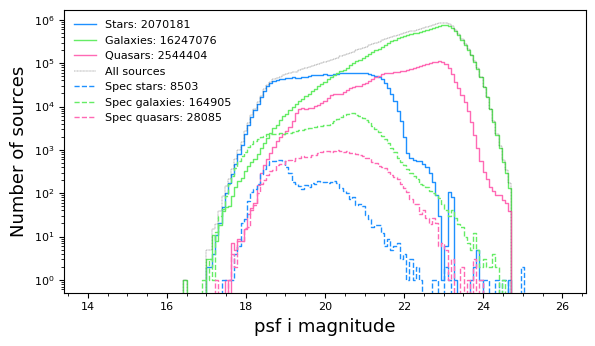

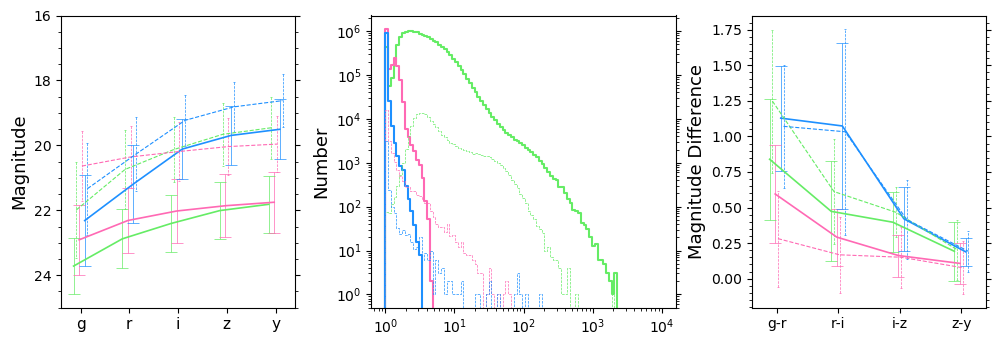

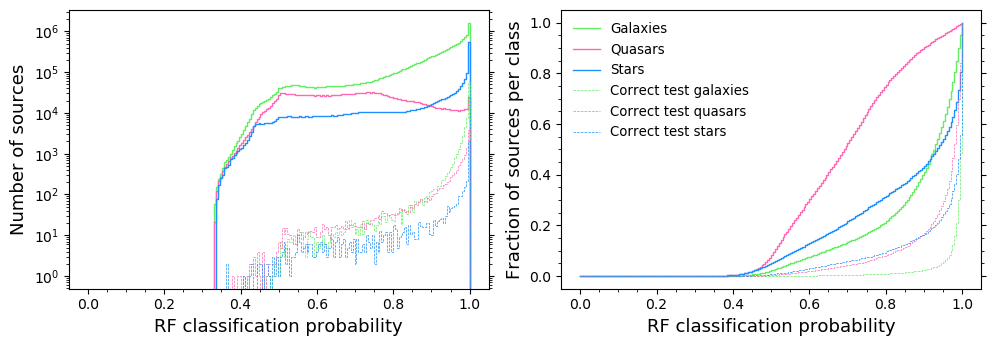

In [15]:
mag_lim = True
# ishape のビン
bins_i = 10 ** np.linspace(np.log10(1), np.log10(10000), 100)

print('Loading df with spec objects...')

if mag_lim:
    df_classified = load_obj('HSC_classifynew/' + place + '/mag_lim/classified_source')
else:
    df_classified = load_obj('HSC_classifynew/' + place + '/no_mag_lim/classified_source')
    
plot_basic_hists(df_classified, df_spec, place)
plot_new_feature_hist(df_spec, df_g, df_q, df_s, place)
plot_new_prob_hist(df_spec, df_g, df_q, df_s, place)

In [12]:
print('Newly classified sources: ')
print(df_classified['class_pred'].value_counts())
print(' Galaxies with prob greater than 0.9 and 0.99: {0}, {1} : as fraction of total: {2:.2f} {3:.2f}'.format( len(df_classified[df_classified['prob_g'] > 0.9]), len(df_classified[df_classified['prob_g'] > 0.99]), len(df_classified[df_classified['prob_g'] > 0.9])/len(df_g), len(df_classified[df_classified['prob_g'] > 0.99])/len(df_g) ) )
print(' Quasars with prob greater than 0.9 and 0.99: {0} {1} : as fraction of total: {2:.2f} {3:.2f}'.format( len(df_classified[df_classified['prob_q'] > 0.9]), len(df_classified[df_classified['prob_q'] > 0.99]), len(df_classified[df_classified['prob_q'] > 0.9])/len(df_q), len(df_classified[df_classified['prob_q'] > 0.99])/len(df_q) ) )
print(' Stars with prob greater than 0.9 and 0.99: {0} {1} : as fraction of total: {2:.2f} {3:.2f}'.format( len(df_classified[df_classified['prob_s'] > 0.9]), len(df_classified[df_classified['prob_s'] > 0.99]), len(df_classified[df_classified['prob_s'] > 0.9])/len(df_s), len(df_classified[df_classified['prob_s'] > 0.99])/len(df_s) ) )

print(df_classified['class_pred'].value_counts())
print(' Galaxies with prob greater than 0.7 and 0.8: {0}, {1} : as fraction of total: {2:.2f} {3:.2f}'.format( len(df_classified[df_classified['prob_g'] > 0.7]), len(df_classified[df_classified['prob_g'] > 0.8]), len(df_classified[df_classified['prob_g'] > 0.7])/len(df_g), len(df_classified[df_classified['prob_g'] > 0.8])/len(df_g) ) )
print(' Quasars with prob greater than 0.7 and 0.8: {0} {1} : as fraction of total: {2:.2f} {3:.2f}'.format( len(df_classified[df_classified['prob_q'] > 0.7]), len(df_classified[df_classified['prob_q'] > 0.8]), len(df_classified[df_classified['prob_q'] > 0.7])/len(df_q), len(df_classified[df_classified['prob_q'] > 0.8])/len(df_q) ) )
print(' Stars with prob greater than 0.7 and 0.8: {0} {1} : as fraction of total: {2:.2f} {3:.2f}'.format( len(df_classified[df_classified['prob_s'] > 0.7]), len(df_classified[df_classified['prob_s'] > 0.8]), len(df_classified[df_classified['prob_s'] > 0.7])/len(df_s), len(df_classified[df_classified['prob_s'] > 0.8])/len(df_s) ) )

Newly classified sources: 
GALAXY    16247076
QSO        2544404
STAR       2070181
Name: class_pred, dtype: int64
 Galaxies with prob greater than 0.9 and 0.99: 9556156, 1634035 : as fraction of total: 0.59 0.10
 Quasars with prob greater than 0.9 and 0.99: 248881 25186 : as fraction of total: 0.10 0.01
 Stars with prob greater than 0.9 and 0.99: 1168017 551240 : as fraction of total: 0.56 0.27
GALAXY    16247076
QSO        2544404
STAR       2070181
Name: class_pred, dtype: int64
 Galaxies with prob greater than 0.7 and 0.8: 14070368, 12723239 : as fraction of total: 0.87 0.78
 Quasars with prob greater than 0.7 and 0.8: 1212380 623837 : as fraction of total: 0.48 0.25
 Stars with prob greater than 0.7 and 0.8: 1624271 1415048 : as fraction of total: 0.78 0.68
